In [1]:
%load_ext autoreload
%autoreload 2
from scripts.load_data import load_raw_data
import numpy as np
import matplotlib.pyplot as plt
berea_files_lst = load_raw_data('Berea')

# list of digital rock files for "Berea"
berea_files_lst

['c:\\100_Research\\digital_rock\\dataset\\Berea_2d25um_binary.raw',
 'c:\\100_Research\\digital_rock\\dataset\\Berea_2d25um_grayscale.raw',
 'c:\\100_Research\\digital_rock\\dataset\\Berea_2d25um_grayscale_filtered.raw']

In [2]:
# load grayscale, filtered, and binary images into numpy.ndarray
from scripts.load_data import load_with_keyword_among_list
raw = load_with_keyword_among_list(berea_files_lst, 'grayscale.raw')
filtered = load_with_keyword_among_list(berea_files_lst, 'filtered.raw')
binary = load_with_keyword_among_list(berea_files_lst, 'binary.raw')

In [7]:
%matplotlib qt5

In [16]:
from scripts.visualization import show_raw_filtered_binary
fig = show_raw_filtered_binary(raw=result["images"][-2] , filtered=result["images"][-3], binary=1-binary, slice_idx=0)
plt.show()

In [ ]:
from scripts.pipeline import Step, run_pipeline
from scripts.denoising import denoise_fourier, denoise_non_local_means, denoise_tv
from scripts.segmentation import segment_otsu, segment_watershed_labels
from scripts.contrast_control import contrast_stretch
from scripts.visualization import plot_pipeline_with_hists

PIPELINE = [
    Step("fourier", denoise_fourier),
    Step("nlm", denoise_non_local_means),
    Step("contrast_stretch", contrast_stretch),
    Step("tv", denoise_tv),
    Step("otsu", segment_otsu),                  # returns mask
    # Step("watershed", segment_watershed_labels), # takes mask -> labels
]

PARAMS = {
    "fourier": dict(
        kind="lowpass",
        cutoff_high=0.16,
        transition=0.04,
        preserve_dtype=True,
    ),

    "nlm": dict(
        patch_size=7,         # bigger patches are more stable in noisy CT
        patch_distance=9,     # wider search reduces speckle
        h=None,
        fast_mode=True,
        preserve_dtype=True,
    ),

    "contrast_stretch": dict(
        p_low=0.5,
        p_high=99.5,
    ),

    "tv": dict(
        weight=0.2,          # stronger edge-aware smoothing to kill boundary halos
        max_num_iter=250,
        eps=2e-4,
        preserve_dtype=True,
    ),

    "otsu": dict(
        pore_is_dark=True,
        min_size=1,         # aggressively remove tiny false pores
        opening_radius=0,     # stronger cleanup
        closing_radius=0,
    ),

    "watershed": dict(
        mask_is_pore=True,
        min_size=0,
        opening_radius=0,
        closing_radius=0,
        peak_footprint_radius=3,  # fewer markers -> less over-segmentation
        min_peak_distance=5,      # enforce separation between seeds
        compactness=0.0,
        connectivity=1,
    ),
}


In [18]:
# Select a single 2D slice from the raw 3D CT volume - Assumes raw has shape [Z, H, W]
raw_image = raw[0]
# Run the full digital rock processing pipeline on the slice
result = run_pipeline(raw_image, PIPELINE, PARAMS)
# Visualize the pipeline results:
# plot_pipeline_with_hists(raw_image, result, PIPELINE);

In [9]:
# difference between new and old filtered images:
from scripts.visualization import show_signed_difference_3col
show_signed_difference_3col(
    image_1=1-binary[0],         # <- from the digital rock portal dataset
    image_2=result["images"][-2] # <- from our pipeline
)

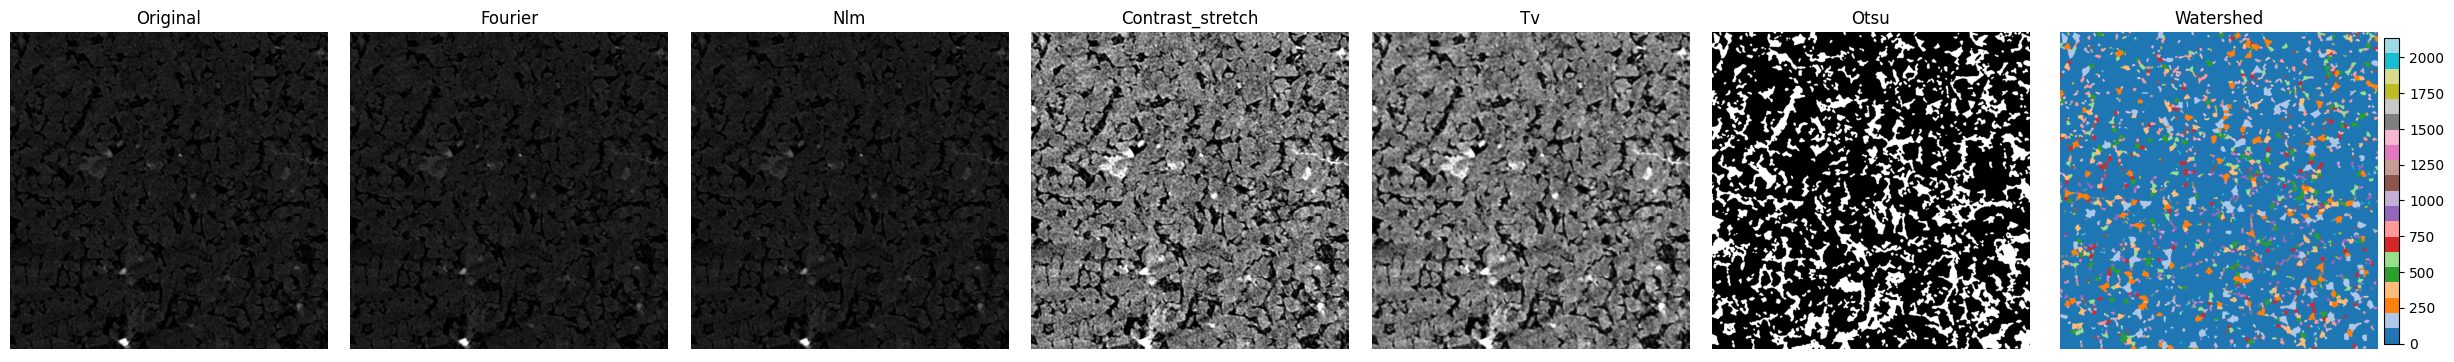

In [ ]:
# (appendix) you can also visualize using another function:
from scripts.visualization import show_pipeline_results
show_pipeline_results(raw_image, result, PIPELINE);

---

(outdated_demo)

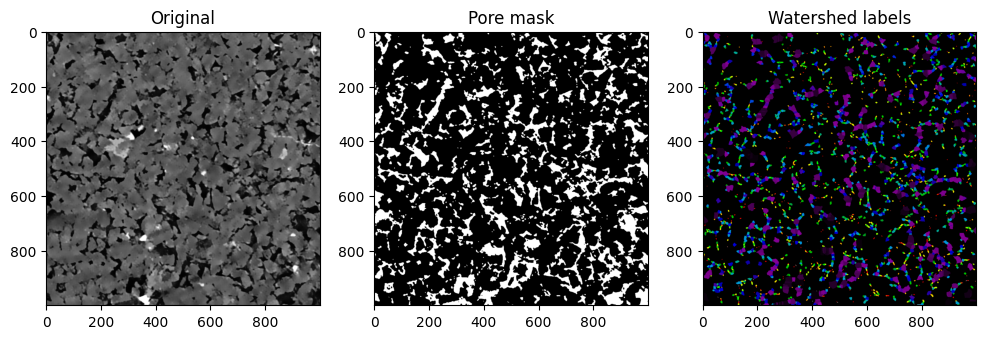

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, morphology, segmentation, feature
from scipy import ndimage as ndi

# Suppose img is your normalized grayscale image
img = filtered[0,:,:]
# Step 1: threshold (Otsu)
T = filters.threshold_otsu(img)
pore = img < T

# Clean small noise
pore = morphology.remove_small_objects(pore, 5)

# Step 2: distance transform
dist = ndi.distance_transform_edt(pore)

# Step 3: find markers
coords = feature.peak_local_max(dist, footprint=np.ones((3,3)), labels=pore)
markers = np.zeros_like(dist, dtype=int)
for i, (r,c) in enumerate(coords, start=1):
    markers[r,c] = i

# Step 4: watershed
labels = segmentation.watershed(-dist, markers, mask=pore)

# Visualize
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1,3,2); plt.imshow(pore, cmap='gray'); plt.title("Pore mask")
plt.subplot(1,3,3); plt.imshow(labels, cmap='nipy_spectral'); plt.title("Watershed labels")
plt.show()


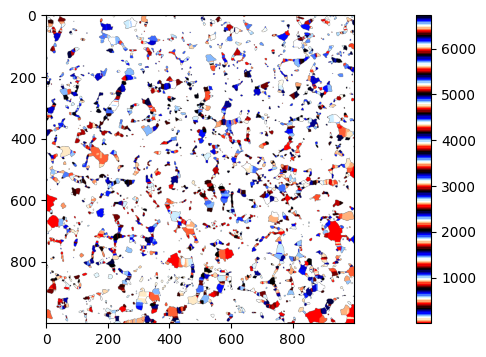

In [83]:
plt.figure(figsize=(16,4))
labels=labels.astype(float)
labels[labels==0] = np.nan  # Hide background for better visualization
plt.imshow(labels, cmap='flag')
plt.colorbar()

In [85]:
labels

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 19., 19., 19.],
       [nan, nan, nan, ..., 19., 19., 19.],
       [nan, nan, nan, ..., 19., 19., 19.]])

(array([562., 488., 388., 525., 399., 409., 389., 332., 318., 286., 197.,
        164., 109.,  86.,  81.,  76.,  63.,  37.,  33.,  26.,  17.,   8.,
          6.,   2.,   2.]),
 array([0.77815125, 0.87069188, 0.96323251, 1.05577314, 1.14831376,
        1.24085439, 1.33339502, 1.42593565, 1.51847628, 1.6110169 ,
        1.70355753, 1.79609816, 1.88863879, 1.98117942, 2.07372005,
        2.16626067, 2.2588013 , 2.35134193, 2.44388256, 2.53642319,
        2.62896382, 2.72150444, 2.81404507, 2.9065857 , 2.99912633,
        3.09166696]),
 <BarContainer object of 25 artists>)

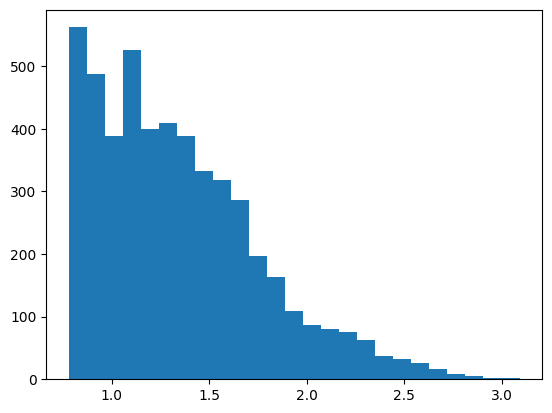

In [98]:
# psd = []
# for i in range(1, labels.max()+1):
#     psd.append(np.sum(labels == i))
psd = np.array(psd)
psd = psd[psd>4]  # Remove zero entries
plt.hist(np.log10(psd), bins=25)

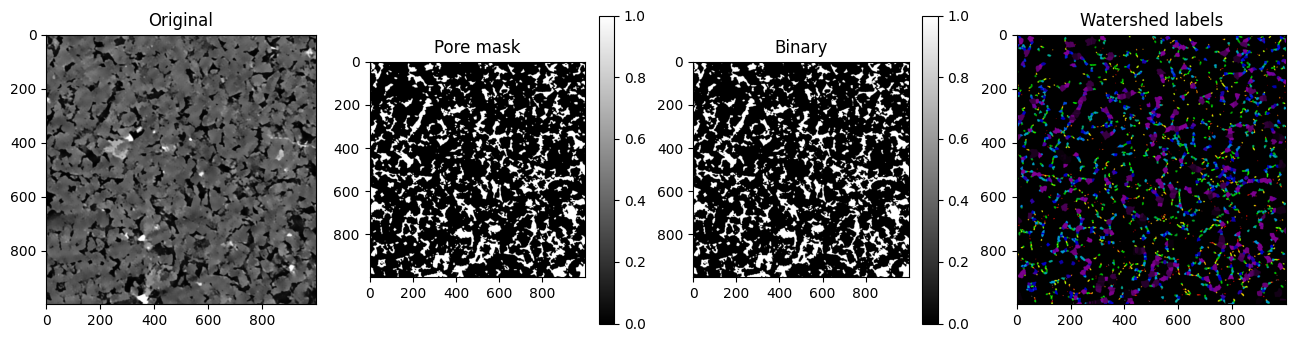

In [68]:
# Visualize
plt.figure(figsize=(16,4))
plt.subplot(1,4,1); plt.imshow(img, cmap='gray'); plt.title("Original")
plt.subplot(1,4,2); plt.imshow(pore, cmap='gray'); plt.title("Pore mask")
plt.colorbar()
plt.subplot(1,4,3); plt.imshow(1- binary[0,:,:], cmap='gray'); plt.title("Binary")
plt.colorbar()
plt.subplot(1,4,4); plt.imshow(labels, cmap='nipy_spectral'); plt.title("Watershed labels")
plt.show()
